Goal of the Competition

The goal of this competition is to predict how DNA, RNA, and protein measurements co-vary in single cells as bone marrow stem cells develop into more mature blood cells. You will develop a model trained on a subset of 300,000-cell time course dataset of CD34+ hematopoietic stem and progenitor cells (HSPC) from four human donors at five time points generated for this competition by Cellarity, a cell-centric drug creation company.

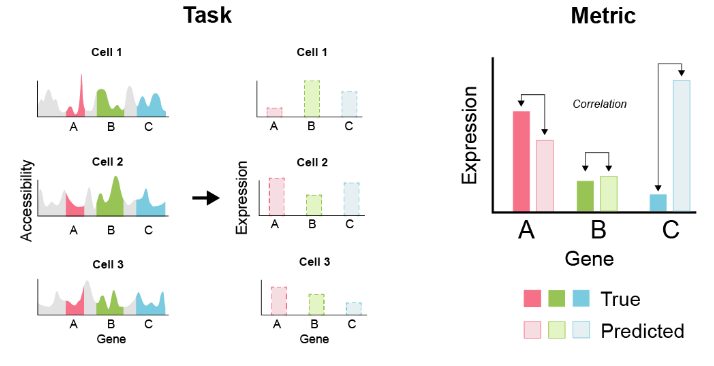

In the test set, taken from an unseen later time point in the dataset, competitors will be provided with one modality and be tasked with predicting a paired modality measured in the same cell. The added challenge of this competition is that the test data will be from a later time point than any time point in the training data.

Your work will help accelerate innovation in methods of mapping genetic information across layers of cellular state. If we can predict one modality from another, we may expand our understanding of the rules governing these complex regulatory processes.



In [1]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error

DATA_DIR = "/kaggle/input/open-problems-multimodal/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

In [2]:
# If you see a warning "Failed to establish a new connection" running this cell,
# go to "Settings" on the right hand side, 
# and turn on internet. Note, you need to be phone verified.
# We need this library to read HDF files.
!pip install --quiet tables


# Loading the common metadata table

The current version of the model is so primitive that it doesn't use the metadata, but we load it anyway.

In [3]:
df_cell = pd.read_csv(FP_CELL_METADATA)
df_cell_cite = df_cell[df_cell.technology=="citeseq"]
df_cell_multi = df_cell[df_cell.technology=="multiome"]
df_cell_cite.shape, df_cell_multi.shape

# The scoring function

This competition has a special metric: For every row, it computes the Pearson correlation between y_true and y_pred, and then all these correlation coefficients are averaged.

In [4]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
    return corrsum / len(y_true)


# Cross-validation

Data size:
- The training input has shape 70988\*22050 (10.6 GByte).
- The training labels have shape 70988\*140.
- The test input has shape 48663\*22050 (4.3 GByte).

To get a result with only 16 GByte RAM, we simplify the problem as follows:
- We ignore the complete metadata (donors, days, cell types).
- We drop all feature columns which are constant.
- Of the remaining columns, we keep only the last 12000.
- We do a PCA and keep only the 240 most important components.
- We use PCA(copy=False), which overwrites its input in fit_transform().
- We fit a ridge regression model with 70988\*240 inputs and 70988\*140 outputs. 

In [ ]:
%%time
# Preprocessing

class PreprocessCiteseq(BaseEstimator, TransformerMixin):
    columns_to_use = 12000
    
    @staticmethod
    def take_column_subset(X):
        return X[:,-PreprocessCiteseq.columns_to_use:]
    
    def transform(self, X):
        print(X.shape)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        X = self.pca.transform(X)
        print(X.shape)
        return X

    def fit_transform(self, X):
        gc.collect()
        print(X.shape)
        self.all_zero_columns = (X == 0).all(axis=0)
        X = X[:,~self.all_zero_columns]
        print(X.shape)
        X = PreprocessCiteseq.take_column_subset(X) # use only a part of the columns
        print(X.shape)
        gc.collect()

        self.pca = PCA(n_components=240, copy=False, random_state=1)
        X = self.pca.fit_transform(X)
        plt.plot(self.pca.explained_variance_ratio_.cumsum())
        plt.title("Cumulative explained variance ratio")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.xlabel('PCA component')
        plt.ylabel('Cumulative explained variance ratio')
        plt.show()
        print(X.shape)
        return X

preprocessor = PreprocessCiteseq()

cite_train_x = None
cite_train_x = preprocessor.fit_transform(pd.read_hdf(FP_CITE_TRAIN_INPUTS).values)

cite_train_y = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values
print(cite_train_y.shape)

In [ ]:
%%time
# Cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=1)
score_list = []
for fold, (idx_tr, idx_va) in enumerate(kf.split(cite_train_x)):
    model = None
    gc.collect()
    X_tr = cite_train_x[idx_tr] # creates a copy, https://numpy.org/doc/stable/user/basics.copies.html
    y_tr = cite_train_y[idx_tr]

    model = Ridge(copy_X=False) # overwrites the copied data
    model.fit(X_tr, y_tr)
    del X_tr, y_tr
    gc.collect()

    # We validate the model
    X_va = cite_train_x[idx_va]
    y_va = cite_train_y[idx_va]
    y_va_pred = model.predict(X_va)
    mse = mean_squared_error(y_va, y_va_pred)
    corrscore = correlation_score(y_va, y_va_pred)
    del X_va, y_va

    print(f"Fold {fold}: mse = {mse:.5f}, corr =  {corrscore:.3f}")
    score_list.append((mse, corrscore))

# Show overall score
result_df = pd.DataFrame(score_list, columns=['mse', 'corrscore'])
print(f"{Fore.GREEN}{Style.BRIGHT}Average  mse = {result_df.mse.mean():.5f}; corr = {result_df.corrscore.mean():.3f}{Style.RESET_ALL}")


This ridge regression is far better than DummyRegressor, which has the score `mse = 4.87618; corr = 0.805`.

# Retraining

We retrain the model on all training rows, delete the training data, load the test data and compute the predictions.

In [7]:
model = None # free the RAM occupied by the old model
model = Ridge(copy_X=False) # we overwrite the training data
model.fit(cite_train_x, cite_train_y)
del cite_train_x, cite_train_y
gc.collect()

cite_test_x = preprocessor.transform(pd.read_hdf(FP_CITE_TEST_INPUTS).values)
test_pred = model.predict(cite_test_x)
del cite_test_x
test_pred.shape

# Submission

We save the CITEseq predictions so that they can be merged with the Multiome predictions in the [Multiome quickstart notebook](https://www.kaggle.com/ambrosm/msci-multiome-quickstart).

The CITEseq test predictions produced by the ridge regressor have 48663 rows (i.e., cells) and 140 columns (i.e. proteins). 48663 * 140 = 6812820.


In [8]:
with open('citeseq_pred.pickle', 'wb') as f: pickle.dump(test_pred, f) # float32 array of shape (48663, 140)

The final submission will have 65744180 rows, of which the first 6812820 are for the CITEseq predictions and the remaining 58931360 for the Multiome predictions. 

We now read the Multiome predictions and merge the CITEseq predictions into them:

In [9]:
with open("../input/msci-multiome-quickstart/partial_submission_multi.pickle", 'rb') as f: submission = pickle.load(f)
submission.iloc[:len(test_pred.ravel())] = test_pred.ravel()
assert not submission.isna().any()
submission = submission.round(6) # reduce the size of the csv
submission.to_csv('submission.csv')
submission
